In [24]:
import numpy as np
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt

In [25]:
def compute_data_cost(I1, I2, num_disp_values, Tau):
    """data_cost: a 3D array of size height x width x num_disp_value;
    data_cost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    The cost is min(1/3 ||I1[y,x]-I2[y,x-l]||_1, Tau)."""
    h, w, _ = I1.shape
    dataCost = np.zeros((h, w, num_disp_values))
    for d in range(num_disp_values):
        shifted_I2 = np.roll(I2, d, axis=1)
        cost = np.linalg.norm(I1 - shifted_I2, ord=1, axis=2)/3  # Compute the L1-norm and normalize
        cost[:, -d:] = Tau  # Handle border effects
        dataCost[:, :, d] = np.minimum(cost, Tau)
    return dataCost

In [26]:
def compute_energy(dataCost, disparity, Lambda):
    """dataCost: a 3D array of size: height x width x num_disp_values;
    dataCost(y,x,l) is the cost of assigning the label l to pixel (y,x).
    disparity: array of size height x width containing disparity of each pixel.
    (an integer between 0 and num_disp_values-1)
    Lambda: a scalar value.
    Return total energy, a scalar value"""
    h, w = disparity.shape

    # Data cost part
    data_cost_energy = np.sum(dataCost[np.arange(h)[:, None], np.arange(w), disparity])

    # Smothness costs for 4 neighbors
    cost_up = Lambda * (disparity != np.roll(disparity, 1, axis=0))
    cost_left = Lambda * (disparity != np.roll(disparity, 1, axis=1))
    cost_down = Lambda * (disparity != np.roll(disparity, -1, axis=0))
    cost_right = Lambda * (disparity != np.roll(disparity, -1, axis=1))

    # Ignoring edge costs
    cost_up[0, :], cost_left[:, 0], cost_down[-1, :], cost_right[:, -1] = 0, 0, 0, 0

    # Summing to get smoothness energy
    smoothness_cost_energy = np.sum(cost_up) + np.sum(cost_down) + np.sum(cost_left) + np.sum(cost_right)

    return data_cost_energy + smoothness_cost_energy   #total

<b>Remark</b>: <br>
Let's clarify the meaning of messages in this code:<br>
 - <b>MsgUPrev</b>(y,x) : message <b>sent</b> from (y,x) to the pixel above it (Up) $⇑$.
 - <b>MsgRPrev</b>(y,x) : message <b>sent</b> from (y,x) to the pixel to its Right $⇒$.<br>

So to get for each pixel (y,x) his <b>received messages</b>, we should encode that:<br>
 - <b>msg_from_U_neighbour</b> : MsgDPrev of pixel (y-1,x) $⇓$.
 - <b>msg_from_R_neighbour</b> : MsgLPrev of pixel (y,x+1) $⇐$.

Thus the `np.roll` calls in the function `update_msg`.

In [27]:
def update_msg(msgUPrev, msgDPrev, msgLPrev, msgRPrev, dataCost, Lambda):
    """Update message maps.
    dataCost: 3D array, depth=label number.
    msgUPrev, msgDPrev, msgLPrev, msgRPrev: 3D arrays (same dims) of old messages.
    Lambda: scalar value
    Return msgU, msgD, msgL, msgR: updated messages"""
    h, w, num_labels = dataCost.shape

    # Getting received messages from previous messages
    msg_from_U_neighbour, msg_from_D_neighbour = np.roll(msgDPrev, 1, axis=0), np.roll(msgUPrev, -1, axis=0)
    msg_from_L_neighbour, msg_from_R_neighbour = np.roll(msgRPrev, 1, axis=1), np.roll(msgLPrev, -1, axis=1)

    # Computing f_t for each direction, then min(f_t)
    fU = dataCost + msg_from_D_neighbour + msg_from_L_neighbour + msg_from_R_neighbour
    fD = dataCost + msg_from_U_neighbour + msg_from_L_neighbour + msg_from_R_neighbour
    fL = dataCost + msg_from_U_neighbour + msg_from_D_neighbour + msg_from_R_neighbour
    fR = dataCost + msg_from_U_neighbour + msg_from_D_neighbour + msg_from_L_neighbour

    min_fU = np.min(fU, axis=2, keepdims=True)
    min_fD = np.min(fD, axis=2, keepdims=True)
    min_fL = np.min(fL, axis=2, keepdims=True)
    min_fR = np.min(fR, axis=2, keepdims=True)

    # Updating messages using the optimized formula
    msgU = np.minimum(fU, Lambda + min_fU)
    msgD = np.minimum(fD, Lambda + min_fD)
    msgL = np.minimum(fL, Lambda + min_fL)
    msgR = np.minimum(fR, Lambda + min_fR)

    # Handling boundaries by keeping messages=0
    msgU[0, :, :], msgD[-1, :, :], msgL[:, 0, :], msgR[:, -1, :]  = 0, 0, 0, 0

    return msgU, msgD, msgL, msgR

In [50]:
def normalize_msg(msgU,msgD,msgL,msgR):
    """Subtract mean along depth dimension from each message"""
    avg=np.mean(msgU,axis=2)
    msgU -= avg[:,:,np.newaxis]
    avg=np.mean(msgD,axis=2)
    msgD -= avg[:,:,np.newaxis]
    avg=np.mean(msgL,axis=2)
    msgL -= avg[:,:,np.newaxis]
    avg=np.mean(msgR,axis=2)
    msgR -= avg[:,:,np.newaxis]
    return msgU,msgD,msgL,msgR

def compute_belief(dataCost,msgU,msgD,msgL,msgR):
    """Compute beliefs, sum of data cost and messages from all neighbors"""
    msg_from_U, msg_from_D = np.roll(msgD, 1, axis=0), np.roll(msgU, -1, axis=0)
    msg_from_L, msg_from_R = np.roll(msgR, 1, axis=1), np.roll(msgL, -1, axis=1)
    beliefs= dataCost.copy() + msg_from_U + msg_from_D + msg_from_L + msg_from_R
    #A question: Should sum of received messages And sum of sent messages give the same result ?
    return beliefs

In [51]:
def MAP_labeling(beliefs):
    """Return a 2D array assigning to each pixel its best label from beliefs
    computed so far"""
    return np.argmin(beliefs, axis=2)

#already coded function
def stereo_bp(I1,I2,num_disp_values,Lambda,Tau=15,num_iterations=60):
    """The main function"""
    dataCost = compute_data_cost(I1, I2, num_disp_values, Tau)
    energy = np.zeros((num_iterations)) # storing energy at each iteration
    # The messages sent to neighbors in each direction (up,down,left,right)
    h,w,_ = I1.shape
    msgU=np.zeros((h, w, num_disp_values))
    msgD=np.zeros((h, w, num_disp_values))
    msgL=np.zeros((h, w, num_disp_values))
    msgR=np.zeros((h, w, num_disp_values))

    for iter in range(num_iterations):
        msgU,msgD,msgL,msgR = update_msg(msgU,msgD,msgL,msgR,dataCost,Lambda)
        msgU,msgD,msgL,msgR = normalize_msg(msgU,msgD,msgL,msgR)
        # Next lines unused for next iteration, could be done only at the end
        beliefs = compute_belief(dataCost,msgU,msgD,msgL,msgR)
        disparity = MAP_labeling(beliefs)
        energy[iter] = compute_energy(dataCost,disparity,Lambda)
    return disparity,energy

<ipython-input-59-325c740ccb61>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_left =imageio.imread('imL.png')#imread('tsukuba/imL.png')
<ipython-input-59-325c740ccb61>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_right=imageio.imread('imR.png')#imread('tsukuba/imR.png')


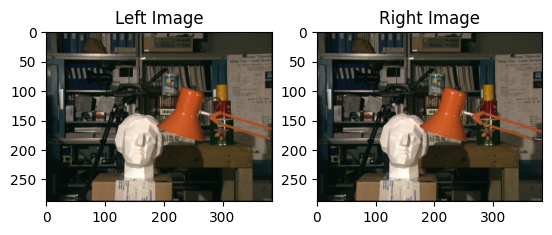

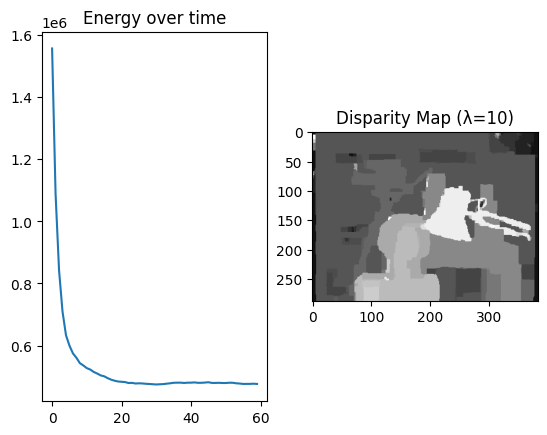

In [59]:
# Input
img_left =imageio.imread('imL.png')#imread('tsukuba/imL.png')
img_right=imageio.imread('imR.png')#imread('tsukuba/imR.png')
plt.subplot(121)
plt.title('Left Image')
plt.imshow(img_left)
plt.subplot(122)
plt.title('Right Image')
plt.imshow(img_right)
plt.show()

# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Parameters
num_disp_values=16 # these images have disparity between 0 and 15.
Lambda=10

# Gaussian filtering
I1=scipy.ndimage.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.gaussian_filter(img_right,0.6)

disparity,energy = stereo_bp(I1,I2,num_disp_values,Lambda)
imageio.imwrite('disparity_{:g}.png'.format(Lambda), (disparity*(255//(num_disp_values-1))).astype(np.uint8))

# Plot results
plt.subplot(121)
plt.title('Energy over time')
plt.plot(energy)
plt.subplot(122)
plt.title(f'Disparity Map (λ={Lambda})')
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.show()